<a href="https://colab.research.google.com/github/fhashmi1982/PGD-Deep-Learning-2024/blob/main/age_gender_and_race_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:19<00:00, 16.5MB/s]
100% 331M/331M [00:19<00:00, 18.1MB/s]


In [5]:
import zipfile

In [6]:
# Unzip the file
zip_file = '/content/utkface-new.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/utkface')

In [7]:
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [8]:
print(len(filenames))
print(filenames[:3])

23708
['26_1_1_20170116011422334.jpg.chip.jpg', '36_0_0_20170116210312217.jpg.chip.jpg', '79_0_0_20170111222200062.jpg.chip.jpg']


# Data preprocessing

In [9]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [10]:
# image_path

# From Unstructured data to Structured data

In [11]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [12]:
#remove outliers
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [13]:
df.head()

,image,age,gender,race
0,30_1_2_20170116161408096.jpg.chip.jpg,30,1,2
1,8_1_0_20170109201107015.jpg.chip.jpg,8,1,0
2,18_1_0_20170109212756182.jpg.chip.jpg,18,1,0
3,43_1_1_20170117193944155.jpg.chip.jpg,43,1,1
4,30_1_0_20170117135257534.jpg.chip.jpg,30,1,0


In [14]:
gender_dict = {0:"Male",1:"Female"}

In [15]:
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [16]:
df.head()

,image,age,gender,race
0,30_1_2_20170116161408096.jpg.chip.jpg,30,1,2
1,8_1_0_20170109201107015.jpg.chip.jpg,8,1,0
2,18_1_0_20170109212756182.jpg.chip.jpg,18,1,0
3,43_1_1_20170117193944155.jpg.chip.jpg,43,1,1
4,30_1_0_20170117135257534.jpg.chip.jpg,30,1,0


In [17]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [18]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [19]:
df.head()

,image,age,gender,race
0,30_1_2_20170116161408096.jpg.chip.jpg,30,1,2
1,8_1_0_20170109201107015.jpg.chip.jpg,8,1,0
2,18_1_0_20170109212756182.jpg.chip.jpg,18,1,0
3,43_1_1_20170117193944155.jpg.chip.jpg,43,1,1
4,30_1_0_20170117135257534.jpg.chip.jpg,30,1,0


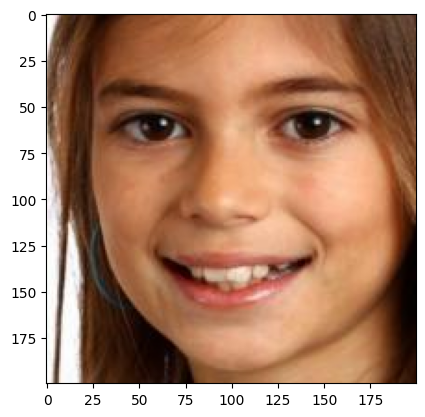

In [20]:
img = Image.open("/content/utkface/UTKFace/"+df['image'][1])
plt.imshow(img)

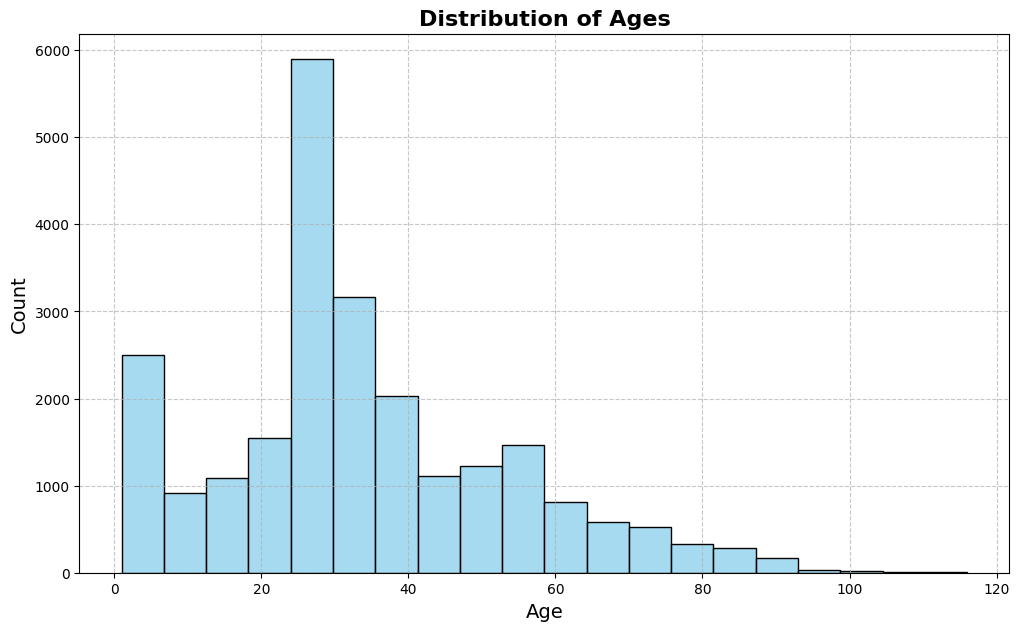

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))


sns.histplot(df['age'], bins=20, kde=False, color='skyblue', edgecolor='black')


plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()


<ipython-input-22-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

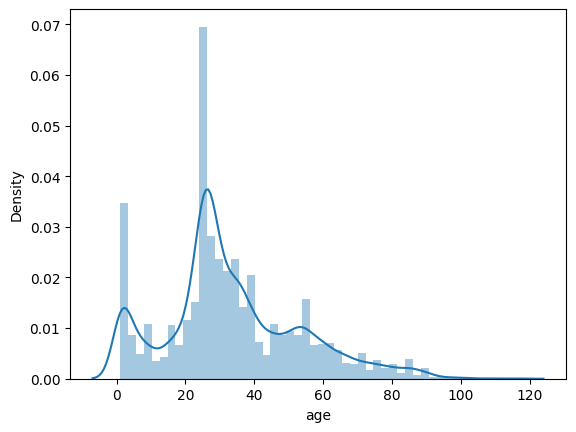

In [22]:
sns.distplot(df.age)

# Plotting Images

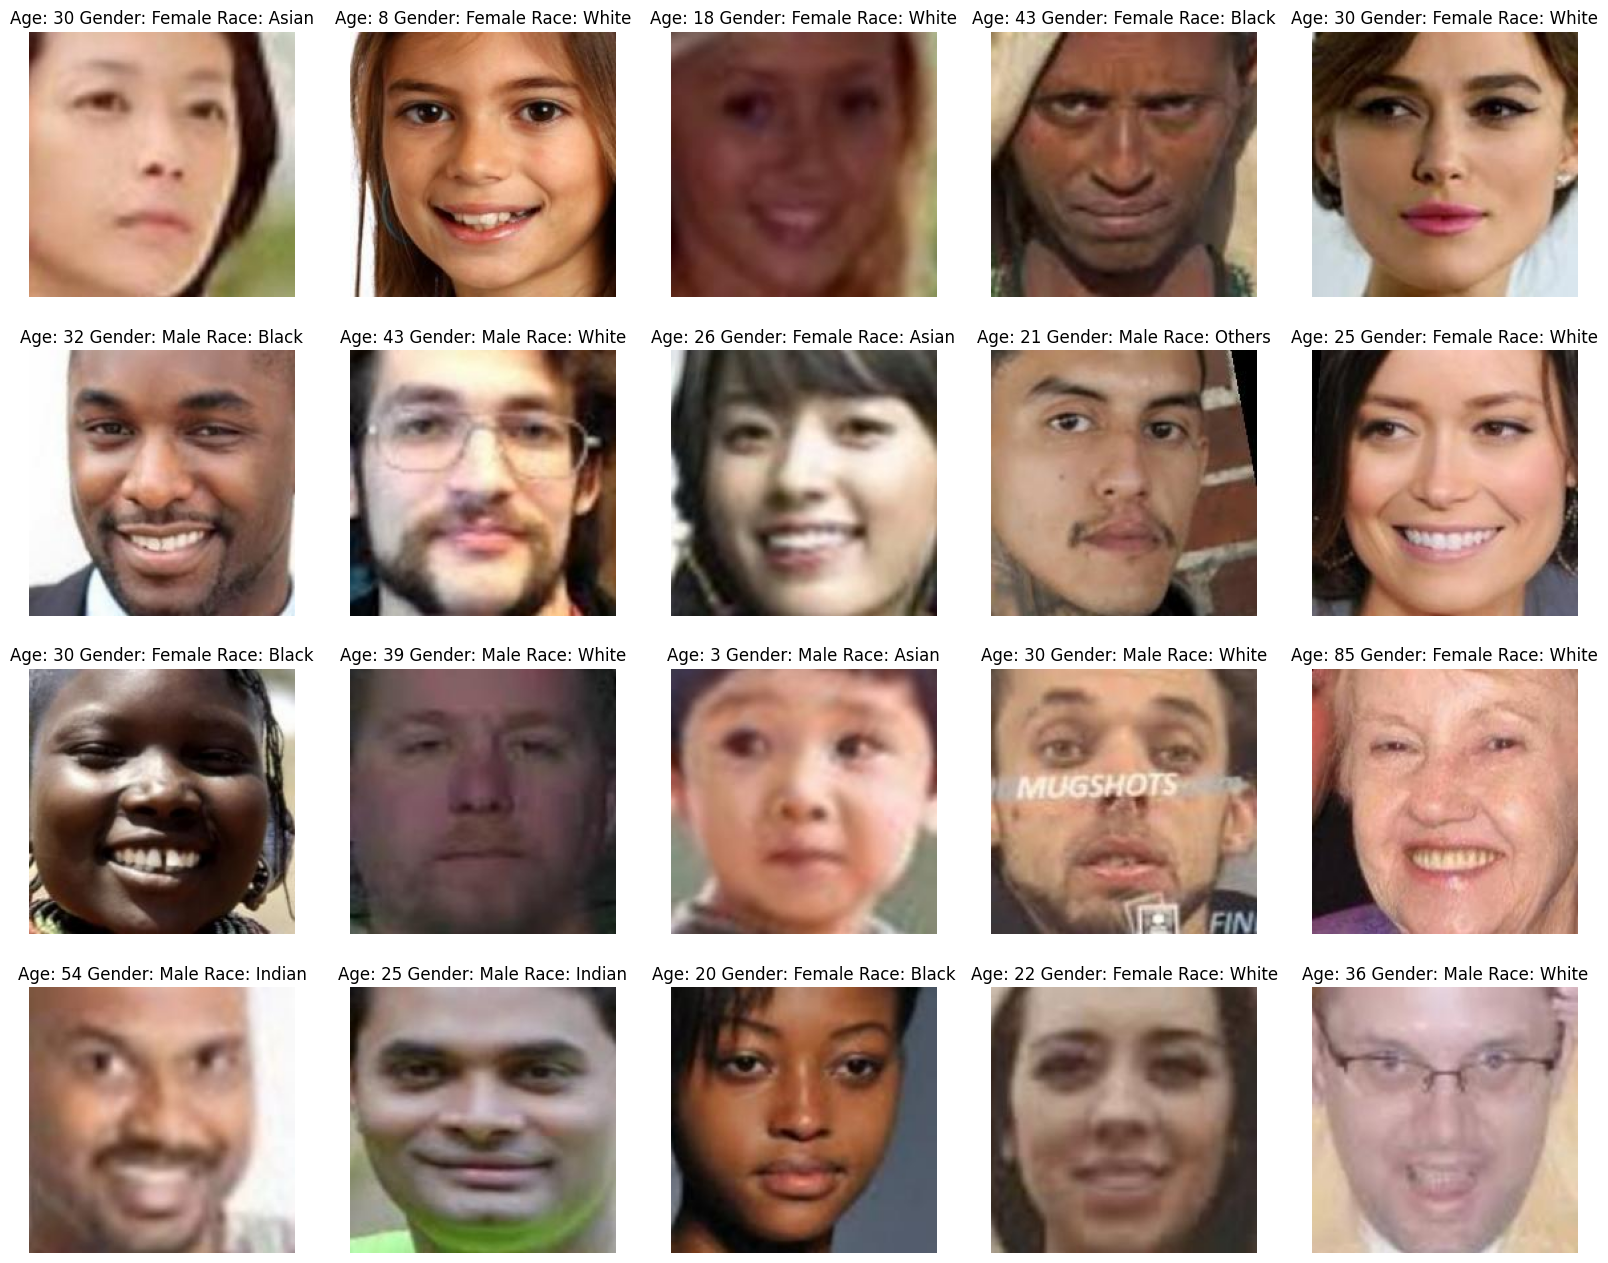

In [23]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset.
I have already shuffled all the data to ensure no biasness in the dataset.

In [24]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [25]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [27]:
train.shape

(18964, 4)

In [28]:
test.shape

(4741, 4)

In [29]:
train.head()

,image,age,gender,race
21099,26_1_3_20170117154857092.jpg.chip.jpg,26,1,3
20882,19_1_4_20170103201818104.jpg.chip.jpg,19,1,4
21549,36_0_0_20170105163417082.jpg.chip.jpg,36,0,0
13630,1_1_4_20161221201836401.jpg.chip.jpg,1,1,4
8225,53_0_0_20170109012812390.jpg.chip.jpg,53,0,0


# Extracting Features

In [ ]:
# print(f"Shape of the first image: {x_train[0].shape}")

In [30]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/utkface/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [31]:
x_train.shape

(18964, 224, 224, 3)

# Normalizing data

In [32]:
# x_train = x_train/255

In [33]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [34]:
from tensorflow.keras.utils import to_categorical

# แปลง race ให้เป็น one-hot encoding
y_race = to_categorical(y_race, num_classes=5)

# Creating model

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform


In [36]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply the VGG16 base model
X = conv_base(inputs)

# Flatten the output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training the model

In [39]:
y_race

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    'best_model_by_race_output.keras',  # Path where the best model will be saved
    monitor='val_race_output_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the metric: 'min' for loss
    verbose=1  # Verbosity level
)

# Train the model with the checkpoint callback
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,  # Set the number of epochs as needed
    batch_size=32,  # Set the batch size as needed
    validation_split=0.1,  # Use a validation split or provide validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 116s 177ms/step - age_output_mean_absolute_error: 26.4418 - gender_output_accuracy: 0.8134 - loss: 2696.1509 - race_output_accuracy: 0.4078 - val_age_output_mean_absolute_error: 13.8252 - val_gender_output_accuracy: 0.8935 - val_loss: 318.2310 - val_race_output_accuracy: 0.4602
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_race_output_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


534/534 ━━━━━━━━━━━━━━━━━━━━ 109s 147ms/step - age_output_mean_absolute_error: 17.7841 - gender_output_accuracy: 0.8899 - loss: 655.6346 - race_output_accuracy: 0.4525 - val_age_output_mean_absolute_error: 15.9451 - val_gender_output_accuracy: 0.8935 - val_loss: 397.2166 - val_race_output_accuracy: 0.5256
Epoch 3/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - age_output_mean_absolute_error: 17.0705 - gender_output_accuracy: 0.9087 - loss: 624.4437 - race_output_accuracy: 0.5088 - val_age_output_mean_absolute_error: 13.3682 - val_gender_output_accuracy: 0.8977 - val_loss: 299.7723 - val_race_output_accuracy: 0.6125
Epoch 4/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - age_output_mean_absolute_error: 16.9366 - gender_output_accuracy: 0.9157 - loss: 627.8480 - race_output_accuracy: 0.5569 - val_age_output_mean_absolute_error: 14.4285 - val_gender_output_accuracy: 0.8914 - val_loss: 339.9432 - val_race_output_accuracy: 0.6268
Epoch 5/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - ag

# Predicting test image

In [41]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [42]:
import numpy

In [43]:
print(np.argmax(y_race[index]))

3


Original: Gender =  Female  Age =  1  Race =  Indian
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Gender =  Female  Age =  9  Race =  Indian


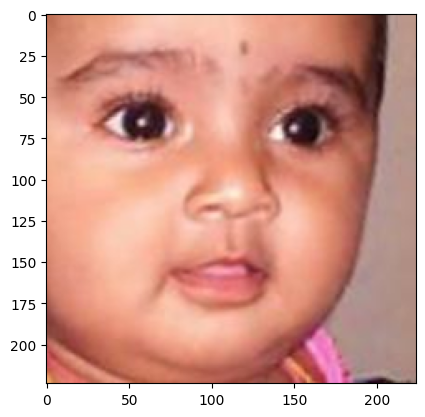

In [44]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index]," Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender," Age = ", pred_age," Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))

In [45]:
test.head()

,image,age,gender,race
17817,45_0_0_20170117185108392.jpg.chip.jpg,45,0,0
15083,33_0_1_20170116215201422.jpg.chip.jpg,33,0,1
22832,29_1_1_20170112205213493.jpg.chip.jpg,29,1,1
16077,45_0_3_20170117121740949.jpg.chip.jpg,45,0,3
8972,53_0_0_20170111201629101.jpg.chip.jpg,53,0,0


In [46]:
#converting Image to numpy array (extracting feature)
x_test = []
for file in test.image:
    img = load_img("/content/utkface/UTKFace/" + file)

    # Resize the image using the correct resampling method
    img = img.resize((224, 224), Image.LANCZOS)

    # Convert the image to a NumPy array
    img = np.array(img)
    x_test.append(img)

# Convert the list of images to a NumPy array
x_test = np.array(x_test)

In [47]:
#converting labels
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [ ]:
test_acc = model.evaluate(x_test, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)

In [48]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])



NameError: name 'test_acc' is not defined

In [49]:
x_test.shape

(4741, 224, 224, 3)

In [50]:
pred = model.predict(x_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step


In [51]:
pred[2][0]

array([0.81793004, 0.00896727, 0.10695271, 0.00809636, 0.05805369],
      dtype=float32)

In [52]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [53]:
#pred to df
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [54]:
df_pred['gender'].value_counts()

,count
gender,
Male,2391
Female,2350


In [55]:
df_pred['age'].value_counts()

,count
age,
9,561
22,219
19,215
21,204
24,203
...,...
78,1
63,1
69,1


In [56]:
df_pred['race'].value_counts()

,count
race,
White,2064
Indian,1198
Black,810
Asian,668
Others,1
